In [1]:
from utils import *
import pandas as pd
import json
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu, hmean
import random
import os
import pickle
import json
import glob
from urllib.parse import urlparse
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

BEST_COLORMAP = 'RdBu_r'

Let's load a bunch of files from previous analysis or from the *user_analysis.ipynb* notebook.

In [2]:
#load entropy information for URLS
df_urls=pd.read_csv('resources/urls_entropy_info.csv')

#load or process URLs information for the TWITIMM dataset. This file was elaborated in a previous project.
if 'urls_clean.dict' in os.listdir('resources'):
    with open('resources/urls_clean.dict','rb') as fi:
        urls_clean=pickle.load(fi)
else:
    picklefile='urls_rt_only.dict'
    urls_clean=clean_urls(picklefile, df_urls, save=False) #from utils.py
    
#load user information from user_analysis.ipynb
user_stats=pd.read_csv('outputs/user_stats.csv')
user_stats['user_id'] = user_stats['user_id'].astype(str)

untrust_dict={str(k):v for k,v in zip(user_stats.user_id,user_stats.harm_fs)}

#load botometer results
with open('outputs/botometer_results_noerrors.dict','rb') as fi:
    results_noerror=pickle.load(fi)
    
df_glob=pd.read_csv('outputs/df_glob.csv')
df_glob['user_id'] = df_glob['user_id'].astype(str)

with open('resources/partition.json','rb') as fi:
    partition=json.load(fi) #loads the community partition obtained through Louvain and explored in previous paper

com_dict={0:'RT1',5:'RT2',7:'RT3',4:'RT4',2:'RT5'} # naming

subpart={k:com_dict[v] for k,v in partition.items() if v in com_dict.keys()} # users in the top 5 communities


In [3]:
#users that ORIGINALLY shared an URL

orig_fake={}
all_chains={}
common_users=set(user_stats.user_id)

for k,v in urls_clean.items():
    orig_list=set([(str(i[2]),i[5]) for i in v if str(i[2]) in common_users])
    orig_fake[k]=orig_list


In [4]:
# users that retweeted

if 'rt_fake.dict' in os.listdir('resources'):
    with open('resources/rt_fake.dict','rb') as fi:
        rt_fake=pickle.load(fi)
else:
    rt_fake={}
    common_users=set(user_stats.user_id)
    for k,v in urls_clean.items():
        rt_list=set([(str(i[0]),i[4]) for i in v if str(i[0]) in common_users])
        rt_fake[k]=rt_list

In [5]:
#let's consider all urls and compute the average botscore and untrustworthiness of the OPs

df_orig=filter_df(orig_fake, df_urls, untrust_dict, results_noerror) #from utils.py
df_orig.head()

df_orig.head()


676
676
676
637


,url,users,unique_users,entropy,avg_u,avg_botscore
0,https://www.loccidentale.it/articoli/145946/mi...,7,7,0.657176,0.005796,0.272000
1,https://www.ilmessaggero.it/primopiano/cronaca...,3,2,0.376097,0.050443,0.140000
2,https://www.linkiesta.it/it/article/2018/07/05...,21,18,0.082553,0.001632,0.314286
3,http://www.altadauniaaltosalento.it/showthread...,1,1,0.000000,0.006517,0.600000
4,http://www.altadauniaaltosalento.it/showthread...,1,1,0.053802,0.006517,0.600000


In [6]:
#let's consider all urls and compute the average botscore and untrustworthiness of the retweeters

df_rt=filter_df(rt_fake,df_urls, untrust_dict, results_noerror) #from utils.py

#classify urls into botscore classes:
l=np.quantile(df_rt.avg_botscore, 0.33)
h=np.quantile(df_rt.avg_botscore, 0.66)
df_rt['botscore_op_class']=df_rt.avg_botscore.apply(eval_item, args=(l,h)) #eval_items in utils.py 
botscore_op_class={k:v for k,v in zip(df_rt.url,df_rt.botscore_op_class)}

df_rt.head()

676
676
676
676


,url,users,unique_users,entropy,avg_u,avg_botscore,botscore_op_class
0,https://www.loccidentale.it/articoli/145946/mi...,399,389,0.657176,0.010298,0.237254,low
1,https://www.ilmessaggero.it/primopiano/cronaca...,90,90,0.376097,0.017042,0.262394,medium
2,https://www.linkiesta.it/it/article/2018/07/05...,299,274,0.082553,0.000356,0.206702,low
3,http://www.altadauniaaltosalento.it/showthread...,215,1,0.000000,0.006517,0.600000,high
4,http://www.altadauniaaltosalento.it/showthread...,209,3,0.053802,0.006539,0.600000,high


In [7]:
#select only users in intersection with botscore > val
val=0.7
high_df=df_glob[df_glob['overall']>=val]

highbot_orig={}
common_users=list(high_df.user_id)
for k,v in urls_clean.items():
    orig_list=([(str(i[0]),i[5]) for i in v if str(i[2]) in common_users]) #OPs with high botscore
    if len(orig_list)>0: 
        highbot_orig[k]=orig_list

In [8]:
df_highbot_orig=filter_df(highbot_orig, df_urls, untrust_dict, results_noerror) #from utils.py

df_highbot_orig['entropy_class']=df_highbot_orig.entropy.apply(eval_item,args=(0.4,0.90))
df_highbot_orig['fakescore_class']=df_highbot_orig.avg_u.apply(eval_item,args=(0.4,0.90))
df_highbot_orig['botscore_class']=df_highbot_orig.avg_botscore.apply(eval_item,args=(0.4,0.90))

df_highbot_orig.head()

308
308
308
303


,url,users,unique_users,entropy,avg_u,avg_botscore,entropy_class,fakescore_class,botscore_class
0,https://www.loccidentale.it/articoli/145946/mi...,16,16,0.657176,0.025772,0.267273,medium,low,low
1,https://www.linkiesta.it/it/article/2018/07/05...,7,6,0.082553,0.000447,0.147143,low,low,low
2,http://www.repubblica.it/cronaca/2018/08/08/ne...,3,3,0.276868,0.000158,0.450000,low,low,medium
3,https://www.ilprimatonazionale.it/politica/moa...,108,108,0.104259,0.018973,0.297753,low,low,low
4,http://ANSAMed.it,4,4,0.496848,0.002983,0.457500,medium,low,medium


In [9]:
val=0.2
low_df=df_glob[df_glob['overall']<=val]

lowbot_orig={}
common_users=list(low_df.user_id)
for k,v in urls_clean.items():
    orig_list=([(str(i[0]),i[5]) for i in v if str(i[2]) in common_users]) #OPs with low botscore
    if len(orig_list)>0: 
        lowbot_orig[k]=orig_list

In [10]:
df_lowbot_orig=filter_df(lowbot_orig, df_urls, untrust_dict, results_noerror) #from utils.py

df_lowbot_orig['entropy_class']=df_lowbot_orig.entropy.apply(eval_item,args=(0.4,0.90))
df_lowbot_orig['fakescore_class']=df_lowbot_orig.avg_u.apply(eval_item,args=(0.4,0.90))
df_lowbot_orig['botscore_class']=df_lowbot_orig.avg_botscore.apply(eval_item,args=(0.4,0.90))

df_lowbot_orig.head()

366
366
366
357


,url,users,unique_users,entropy,avg_u,avg_botscore,entropy_class,fakescore_class,botscore_class
0,https://www.loccidentale.it/articoli/145946/mi...,425,419,0.657176,0.008478,0.246000,medium,low,low
1,https://www.ilmessaggero.it/primopiano/cronaca...,93,93,0.376097,0.016567,0.279710,low,low,low
2,https://www.linkiesta.it/it/article/2018/07/05...,18,18,0.082553,0.000425,0.202500,low,low,low
3,https://www.ilprimatonazionale.it/primo-piano/...,2,2,0.234915,0.006867,0.160000,low,low,low
4,http://www.repubblica.it/cronaca/2018/08/08/ne...,34,34,0.276868,0.001120,0.226333,low,low,low


In [11]:
middle=0.005

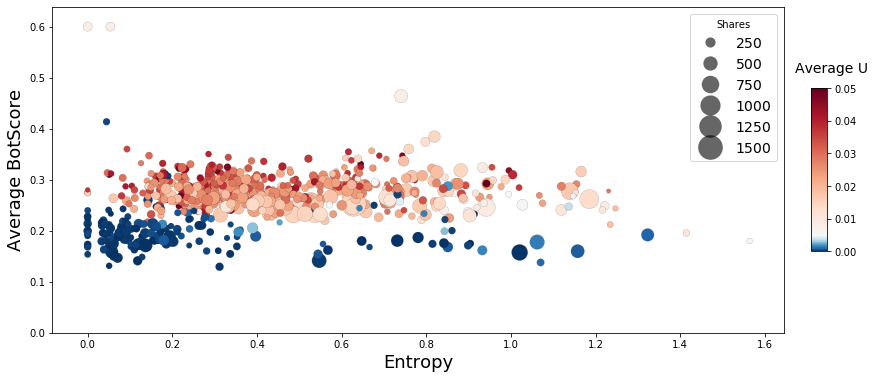

In [12]:
scatter(df_rt, middle, BEST_COLORMAP, 1/2.5,xy = (1.67, 0.51), top_y=False, top_y_val='',save=False, path='')

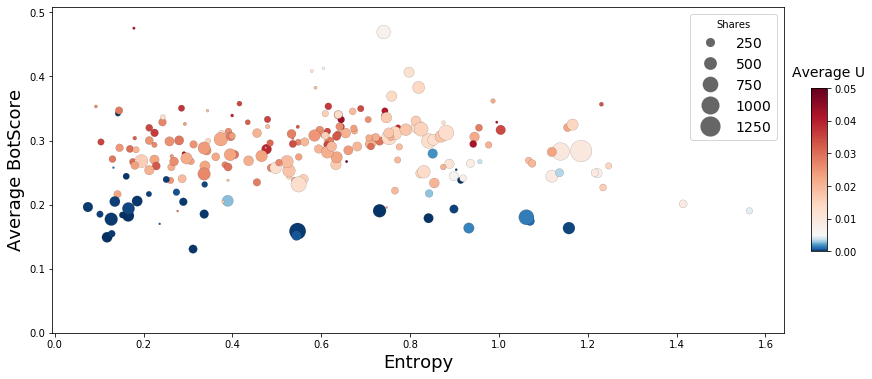

In [13]:
scatter(df_highbot_orig[df_highbot_orig['users']>10], middle,BEST_COLORMAP, 1/2.5, xy=(1.66,0.4), top_y=False, top_y_val='',save=True, path='')


# Further checks

## Positive relationship

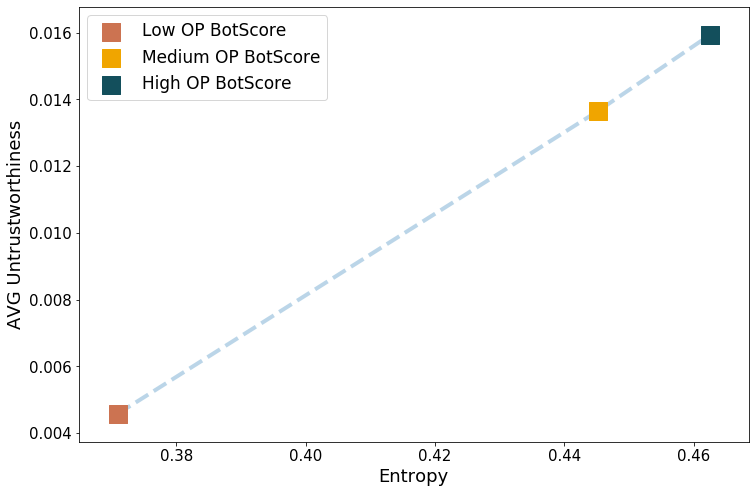

In [14]:
#further check of positive relationship 

tmp=df_rt[['entropy','avg_u','botscore_op_class']].groupby('botscore_op_class').mean().reset_index()
tmp_dict={'low':'Low OP BotScore','medium':'Medium OP BotScore','high':'High OP BotScore'}
tmp['botscore_op_class']=tmp['botscore_op_class'].map(tmp_dict)
tmp=tmp.sort_values('entropy')

col = ['#cc7351','#f0a500','#134f5c']
x = tmp.entropy
y = tmp.avg_u
label=tmp.botscore_op_class


fig=plt.figure(figsize=(12,8))

plt.plot(x,y,'--', alpha=0.3, linewidth=4, zorder=1)
for c, _x, _y, l in zip(col, x, y, label):
    plt.scatter(_x, _y, c=c, label=l, marker='s',alpha=1,s=300,zorder=2)
    plt.legend(prop={'size': 17})
plt.xlabel('Entropy',fontsize=18)
plt.ylabel('AVG Untrustworthiness',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.plot();

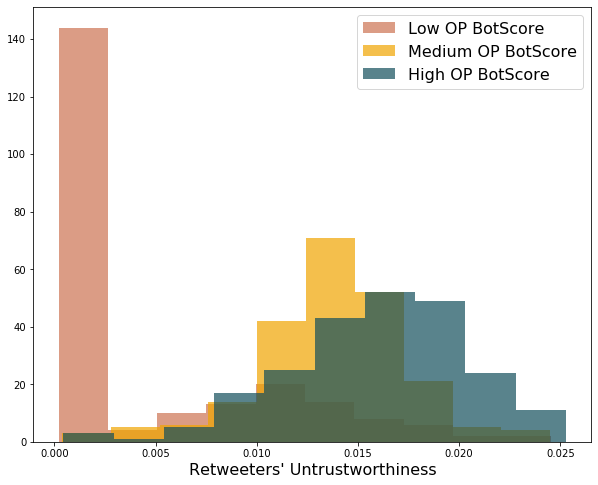

In [15]:
#further check of positive relationship 

df_rt.head()

classes=['low','medium','high']
col = ['#cc7351','#f0a500','#134f5c']


fig, ax=plt.subplots(figsize=(10,8))

for i,c in zip(classes,col):
    tmp=df_rt[df_rt['botscore_op_class']==i]
    tmp_dict={'low':'Low OP BotScore','medium':'Medium OP BotScore','high':'High OP BotScore'}
    tmp['botscore_op_class']=tmp['botscore_op_class'].map(tmp_dict)
    
    sns.distplot(tmp['avg_u'],ax=ax,label=tmp_dict[i],kde=False,color=c, bins=10, hist_kws={'alpha':0.7})
    
    
plt.xlabel("Retweeters' Untrustworthiness", fontsize=16)
plt.legend(prop={'size': 16})

plt.plot();

## Reliable/unreliable quantities

In [16]:
reliable=['repubblica.it','larep.it','twitter.it','corriere.it','virgilio.it','gazzetta.it','upday.com','tgcom24.mediaset.it','libero.it','ilmessaggero.it','ilfattoquotidiano.it','fanpage.it',
          'leggo.it','lastampa.it','tuttomercatoweb.com','giallozafferano.it','sport.sky.it','sky.tg','tg24.sky.it','ansa.it',
          'ANSAMed.it','liberoquotidiano.it','ilgiornale.it','calciomercato.com','huffingtonpost.it','huffp.st','my-personaltrainer.it','bendingspoons.com','espresso.repubblica.it','ilmattino.it','italiaonline.it','ilsole24ore.com','donnamoderna.com','vanityfair.it','corrieredellosport.it','tuttosport.com','tpi.it','tg24.sky.it','ilgazzettino.it','ilpost.it','dailymotion.com','raiplay.it','mediasetplay.mediaset.it','adnkronos.com','notizie.tiscali.it','eurosport.it','tim.it','it.altervista.org','rainews.it','unionesarda.it','mymovies.it','affaritaliani.it','greenme.it','gds.it','smartworld.it','dagospia.com','la7.it','nostrofiglio.it','notizie.it','deejay.it','it.businessinsider.com','formulapassion.it','wired.it','deabyday.tv','ticketone.it','caffeinamagazine.it','milanofinanza.it','elle.com/it/','treccani.it','focus.it','corriereadriatico.it','grazia.it','ilbianconero.com','lacucinaitaliana.it','105.net','blog.cliomakeup.com','fcinternews.it','lanuovasardegna.it','alvolante.it','lagazzettadelmezzogiorno.it','zingarate.com','viamichelin.it','studenti.it','rockol.it','lasicilia.it','ilcentro.it','supereva.it','blitzquotidiano.it','cosmopolitan.it','gazzettadelsud.it','lettera43.it','ilgiornaledivicenza.it','ladyblitz.it','larena.it','wetransfer.com','prealpina.it','discoveryplus.it','quinews.net','filmtv.it','rai.it','quotidianodipuglia.it','iltempo.it','','skuola.net','ilmiolibro.it','marieclaire.com','','glamour.it','','vogue.it','termometropolitico.it','esquire.com','milleunadonna.it','mondadoristore.it']
reliable=[ '.'.join(x.split('.')[-2:]) for x in reliable if x!='']


_unrel=pd.read_csv('resources/fakeurls.csv')
_unrel=_unrel[_unrel['domain_type']=='hoax']
unreliable=_unrel['url'].tolist()
unreliable=['.'.join(urlparse(x).netloc.split('.')[-2:]) for x in unreliable]

reliable=[x for x in reliable if x not in unreliable]

data_reliable=[x for x in df_rt.url if '.'.join(urlparse(x).netloc.split('.')[-2:]) in reliable]
data_unreliable=[x for x in df_rt.url if '.'.join(urlparse(x).netloc.split('.')[-2:]) in unreliable]

In [17]:
df_rt['flag']=['mainstream' if x in data_reliable else 'underground' if x in data_unreliable else 'other' for x in df_rt.url]
ranked=df_rt.sort_values('users',ascending=False)
ranked['ranking']=[x for x in range(1,len(ranked)+1)]
ranked['Domain']=[urlparse(x).netloc for x in ranked.url]

tmp=ranked[['Domain','users','flag']].groupby(['Domain','flag']).sum().reset_index()
tmp=tmp.sort_values('users',ascending=False)
print(tmp.head(16).to_latex(index=False))

\begin{tabular}{llr}
\toprule
                    Domain &         flag &  users \\
\midrule
          www.imolaoggi.it &  underground &  15105 \\
   www.liberoquotidiano.it &   mainstream &  10500 \\
         www.ilgiornale.it &   mainstream &   6872 \\
         www.repubblica.it &   mainstream &   5184 \\
                  larep.it &   mainstream &   3895 \\
 www.riscattonazionale.org &  underground &   3874 \\
  www.ilfattoquotidiano.it &   mainstream &   3386 \\
           www.lastampa.it &   mainstream &   3338 \\
              voxnews.info &  underground &   3200 \\
 www.ilprimatonazionale.it &  underground &   3098 \\
               www.ansa.it &   mainstream &   2428 \\
                  huffp.st &   mainstream &   2393 \\
           www.corriere.it &   mainstream &   2090 \\
      www.secoloditalia.it &        other &   1728 \\
   www.tgcom24.mediaset.it &   mainstream &   1711 \\
       it.blastingnews.com &        other &   1704 \\
\bottomrule
\end{tabular}



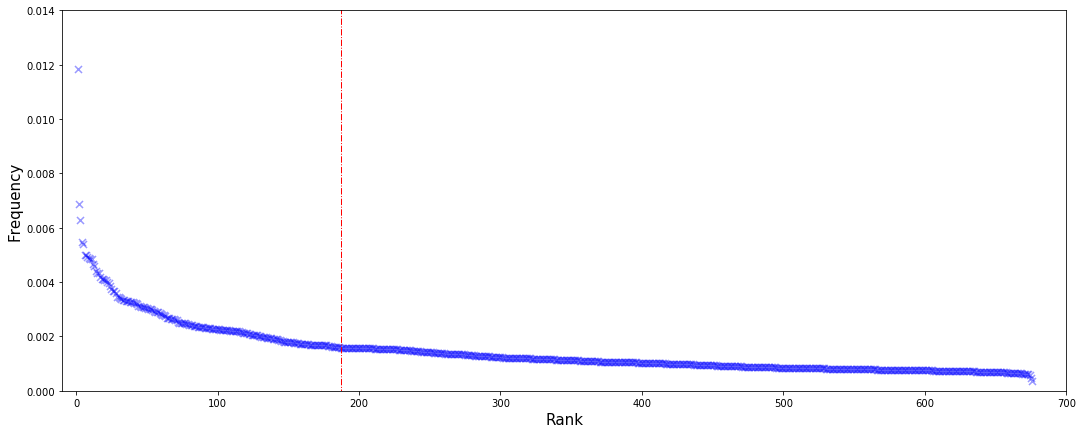

In [18]:
#look for heavy-tailed distribution

tot=np.sum(ranked.users)
mid=tot/2
cumsum=np.cumsum([x for x in ranked.users])

for i,s in enumerate(cumsum):
    if np.abs(mid-s) <100:
        _xline=i
        
a=1.14

fig=plt.figure(figsize=(18,7))
#plt.yscale('log')
#plt.xscale('linear')

x=np.array([np.float(x) for x in ranked.ranking])
#z = x**(-a) / special.zetac(a)


markers={'mainstream':'x','underground':'x','other':'x'}
colors={'mainstream':'blue','underground':'blue','other':'blue'}
sizes={'mainstream':50,'underground':50,'other':50}
alphas={'mainstream':0.4,'underground':0.4,'other':0.4}
zorders={'mainstream':0,'underground':1,'other':2}

for r in ranked.flag.unique():
    tmp=ranked[ranked['flag']==r]
    marker=markers[r]
    color=colors[r]
    size=sizes[r]
    
    x=np.array([np.float(x) for x in tmp.ranking])
    plt.scatter(x,y=[y/np.sum(ranked.users) for y in tmp.users], marker=marker,
            c=color,s=size,alpha=alphas[r], label=r, zorder=zorders[r])

plt.xlim(-10,700)
plt.ylim(0,0.014)


plt.vlines(_xline,ymin=-0.1,ymax=1,color='red',linewidth=1, linestyle='dashdot')
plt.xlabel('Rank',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

In [19]:
#n=128
n=186
highest={k:(v*100)/len(ranked[0:n]) for k,v in Counter(ranked[0:n]['flag']).items()}
lowest={k:(v*100)/len(ranked[n:]) for k,v in Counter(ranked[n:]['flag']).items()}

print('top 50% of shares is made of {} urls, divided as: \n{}'.format(len(ranked[0:n]),highest))
print('bottom 50% of shares is made of {} urls, divided as: \n{}'.format(len(ranked[n:]),lowest))


top 50% of shares is made of 186 urls, divided as: 
{'underground': 22.043010752688172, 'mainstream': 44.623655913978496, 'other': 33.333333333333336}
bottom 50% of shares is made of 490 urls, divided as: 
{'mainstream': 48.775510204081634, 'underground': 21.224489795918366, 'other': 30.0}


In [20]:
#proportion of accounts with urls in each community:
#how many urls per community? how many reliable/unreliable?

com_url={}
count_main=0
count_under=0
count_other=0

for com in set(subpart.values()):
    count_main=0
    count_under=0
    count_other=0
    for k,v in rt_fake.items():
        sub=[[i[0] for i in v]]
        means=[]
        for i in sub:
            vals=[subpart[a] for a in i if a in subpart.keys()]
            d={a:b for a,b in Counter(vals).items()}

            if k in data_reliable:
                try:
                    count_main+=d[com]
                except KeyError:
                    continue
            elif k in data_unreliable:
                try:
                    count_under+=d[com]
                except KeyError:
                    continue
            else:
                try:
                    count_other+=d[com]
                except KeyError:
                    continue
    com_url[com]={'mainstream':count_main,'underground':count_under,'other (unlisted)':count_other,'total':count_main+count_under+count_other}                 

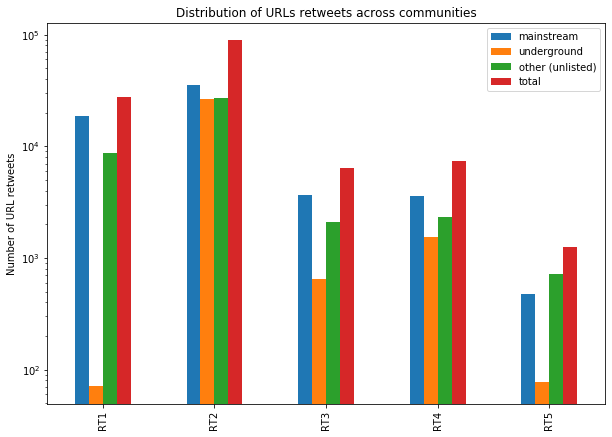

In [21]:
temp=pd.DataFrame(data=com_url)
temp=temp.transpose()
temp=temp.sort_index()

fig,ax=plt.subplots(figsize=(10,7))
temp.plot.bar(ax=ax)
ax.set_yscale('log')
ax.set_title('Distribution of URLs retweets across communities')
ax.set_ylabel('Number of URL retweets')
plt.show()

In [22]:
com_size={'RT1':116831,'RT2':34174,'RT3':27845,'RT4':9553,'RT5':9225}

norm_temp=pd.DataFrame(columns=[x for x in temp.columns])
for i,r in temp.iterrows():
    new_r=r/com_size[i]
    norm_temp=norm_temp.append(new_r)
norm_temp

,mainstream,underground,other (unlisted),total
RT1,0.160454,0.000608,0.074963,0.236025
RT2,1.039006,0.768479,0.793118,2.600603
RT3,0.130329,0.023344,0.074627,0.228300
RT4,0.372762,0.160368,0.244740,0.777871
RT5,0.051057,0.008455,0.077615,0.137127


In [23]:
pvals={}
for i1,r1 in norm_temp.iterrows():
    p_s=[]
    for i2, r2 in norm_temp.iterrows():
        if i2!=i1:
            t,p=mannwhitneyu([x for x in r1],[x for x in r2])
        else:
            p=0
        p_s.append(p)
    pvals[i1]=p_s

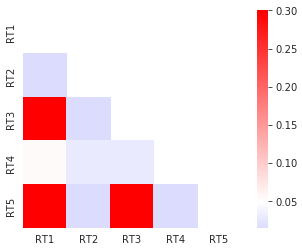

In [24]:
corr = [x for x in pvals.values()]
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, center=0.05, cmap="bwr", xticklabels=[x for x in pvals.keys()],yticklabels=[x for x in pvals.keys()])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [25]:
corr_df=pd.DataFrame(columns=[x for x in pvals.keys()])
for x in corr:
    z=np.array([np.round(y,2) for y in x])
    corr_df=corr_df.append(pd.DataFrame(z.reshape(1,-1), columns=[x for x in pvals.keys()]), ignore_index=True)
corr_df['idx']=[x for x in pvals.keys()]
corr_df=corr_df.set_index('idx')
corr_df

,RT1,RT2,RT3,RT4,RT5
idx,,,,,
RT1,0.00,0.02,0.44,0.06,0.33
RT2,0.02,0.00,0.02,0.03,0.02
RT3,0.44,0.02,0.00,0.03,0.33
RT4,0.06,0.03,0.03,0.00,0.02
RT5,0.33,0.02,0.33,0.02,0.00
